In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

import gc
import os

import warnings
warnings.filterwarnings(action='ignore')

In [13]:
# 나눔 폰트 경로 설정
dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

In [2]:
path='/home/hwchoi/001.project/data/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path)

### Sido Modeling (시도별 환자수 예측)

#### 1. RNN,LSTM sequnce_length 적용 / whole features

In [3]:
# create_date에 대한 sorting 적용
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
df_raw.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df_raw = df_raw.fillna(0)

features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm',
       'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
       'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target='patientsCnt'
print(len(features))

48


In [4]:
# 데이터 스케일링
scaler = StandardScaler()
df_raw[features] = scaler.fit_transform(df_raw[features])

In [5]:
# 입력 시퀀스 준비 함수
def create_sequences(data, features, target, sequence_length):
    X = []
    y = []
    dates = []
    for i in range(len(data) - sequence_length):
        X.append(data[features].iloc[i:i+sequence_length].values)
        y.append(data[target].iloc[i+sequence_length])
        dates.append(data['create_date'].iloc[i+sequence_length])
    return np.array(X), np.array(y), np.array(dates)

sequence_length = 15

In [6]:
# RNN 모델 학습 및 평가
def train_rnn_model(data, sido_cd, features, target, sequence_length):
    data_sido = data[data['sido_cd'] == sido_cd]
    X, y, dates = create_sequences(data_sido, features, target, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    rnn_model = Sequential()
    rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, len(features))))
    rnn_model.add(Dense(1))
    rnn_model.compile(optimizer='adam', loss='mse')
    rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    
    rnn_predictions = rnn_model.predict(X_test).flatten()
    rnn_mae = mean_absolute_error(y_test, rnn_predictions)
    rnn_mse = mean_squared_error(y_test, rnn_predictions)
    rnn_r2 = r2_score(y_test, rnn_predictions)
    
    # 메모리 초기화
    del rnn_model
    gc.collect()
    
    return {'mae': rnn_mae, 'mse': rnn_mse, 'r2': rnn_r2}

In [7]:
# LSTM 모델 학습 및 평가
def train_lstm_model(data, sido_cd, features, target, sequence_length):
    data_sido = data[data['sido_cd'] == sido_cd]
    X, y, dates = create_sequences(data_sido, features, target, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, len(features))))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')
    lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))
    
    lstm_predictions = lstm_model.predict(X_test).flatten()
    lstm_mae = mean_absolute_error(y_test, lstm_predictions)
    lstm_mse = mean_squared_error(y_test, lstm_predictions)
    lstm_r2 = r2_score(y_test, lstm_predictions)
    
    # 메모리 초기화
    del lstm_model
    gc.collect()
    
    return {'mae': lstm_mae, 'mse': lstm_mse, 'r2': lstm_r2}

In [8]:
# RandomForest 모델 학습 및 평가
def train_rf_model(data, sido_cd, features, target):
    data_sido = data[data['sido_cd'] == sido_cd]
    X=data_sido[features]
    y=data_sido['patientsCnt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=11)
    rf_model.fit(X_train, y_train)
    
    rf_predictions = rf_model.predict(X_test)
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)
    
    # 메모리 초기화
    del rf_model
    gc.collect()
    
    return {'mae': rf_mae, 'mse': rf_mse, 'r2': rf_r2}

In [9]:
# XGBoost 모델 학습 및 평가
def train_xgb_model(data, sido_cd, features, target):
    data_sido = data[data['sido_cd'] == sido_cd]
    X=data_sido[features]
    y=data_sido['patientsCnt']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
        
    xgb_model = XGBRegressor(n_estimators=100, random_state=11)
    xgb_model.fit(X_train, y_train)
    
    xgb_predictions = xgb_model.predict(X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    xgb_mse = mean_squared_error(y_test, xgb_predictions)
    xgb_r2 = r2_score(y_test, xgb_predictions)
    
    # 메모리 초기화
    del xgb_model
    gc.collect()
    
    return {'mae': xgb_mae, 'mse': xgb_mse, 'r2': xgb_r2}

In [10]:
# 시도별 결과 저장 딕셔너리
sido_rnn = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_rnn[sido_cd] = {
        'RNN': train_rnn_model(df_raw, sido_cd, features, target, sequence_length)
    }

sido_lstm = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_lstm[sido_cd] = {
        'LSTM': train_lstm_model(df_raw, sido_cd, features, target, sequence_length)
    }

Processing 31...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 57.9710 - val_loss: 20.5269
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.9749 - val_loss: 18.1146
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.2735 - val_loss: 15.9657
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9898 - val_loss: 14.3746
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.6556 - val_loss: 13.5078
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.9174 - val_loss: 12.1055
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.8028 - val_loss: 14.9410
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.3773 - val_loss: 12.6598
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.2210 - val_loss: 11.9923
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.6652 - val_loss: 10.8321
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8370 - val_loss: 10.8250
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━

In [11]:
# 데이터프레임으로 변환
# RNN
rnn_rows = []
for sido_cd, metrics in sido_rnn.items():
    for model, scores in metrics.items():
        row = {'sido_cd': sido_cd, 'model': model}
        row.update(scores)
        rnn_rows.append(row)

rnn_results = pd.DataFrame(rnn_rows)

# LSTM
lstm_rows = []
for sido_cd, metrics in sido_lstm.items():
    for model, scores in metrics.items():
        row = {'sido_cd': sido_cd, 'model': model}
        row.update(scores)
        lstm_rows.append(row)

lstm_results = pd.DataFrame(lstm_rows)

In [12]:
# 데이터프레임을 하나로 합치기
combined_rnn_lstm = pd.concat([rnn_results, lstm_results], axis=0, ignore_index=True)
combined_rnn_lstm.to_csv('modeling_results_rnn_lstm.csv', index=False)

In [10]:
sido_rf = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_rf[sido_cd] = {
        'RandomForest': train_rf_model(df_raw, sido_cd, features, target)
    }

sido_xgb = {}
# 시도별 모델 학습 및 평가
sido_cds = df_raw['sido_cd'].unique()
for sido_cd in sido_cds:
    print(f'Processing {sido_cd}...')
    sido_xgb[sido_cd] = {
        'XGBoost': train_xgb_model(df_raw, sido_cd, features, target)
    }

Processing 31...
Processing 23...
Processing 38...
Processing 26...
Processing 24...
Processing 25...
Processing 32...
Processing 39...
Processing 21...
Processing 11...
Processing 36...
Processing 29...
Processing 37...
Processing 35...
Processing 22...
Processing 33...
Processing 34...
Processing 31...
Processing 23...
Processing 38...
Processing 26...
Processing 24...
Processing 25...
Processing 32...
Processing 39...
Processing 21...
Processing 11...
Processing 36...
Processing 29...
Processing 37...
Processing 35...
Processing 22...
Processing 33...
Processing 34...


In [11]:
# 데이터프레임으로 변환
# RandomForest
rf_rows = []
for sido_cd, metrics in sido_rf.items():
    for model, scores in metrics.items():
        row = {'sido_cd': sido_cd, 'model': model}
        row.update(scores)
        rf_rows.append(row)

rf_results = pd.DataFrame(rf_rows)

# XGB
xgb_rows = []
for sido_cd, metrics in sido_xgb.items():
    for model, scores in metrics.items():
        row = {'sido_cd': sido_cd, 'model': model}
        row.update(scores)
        xgb_rows.append(row)

xgb_results = pd.DataFrame(xgb_rows)

In [12]:
# 데이터프레임을 하나로 합치기
combined_rf_xgb = pd.concat([rf_results, xgb_results], axis=0, ignore_index=True)
combined_rf_xgb.to_csv('modeling_results_rf_xgb.csv', index=False)

### 시각화

In [2]:
df=pd.read_csv('./modeling_results_all.csv')

In [3]:
dt_map = {'39': '제주특별자치도', '32': '강원특별자치도', '25': '대전광역시','21': '부산광역시',
    '24': '광주광역시','26': '울산광역시', '38': '경상남도','23': '인천광역시',
    '31': '경기도','33': '충청북도', '22': '대구광역시','35': '전북특별자치도',
    '37': '경상북도','29': '세종특별자치시','36': '전라남도','11': '서울특별시','34': '충청남도'
}

In [4]:
df['sido'] = df['sido_cd'].astype(str).map(dt_map)

In [5]:
def add_values_on_bars(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

<Figure size 2000x800 with 0 Axes>

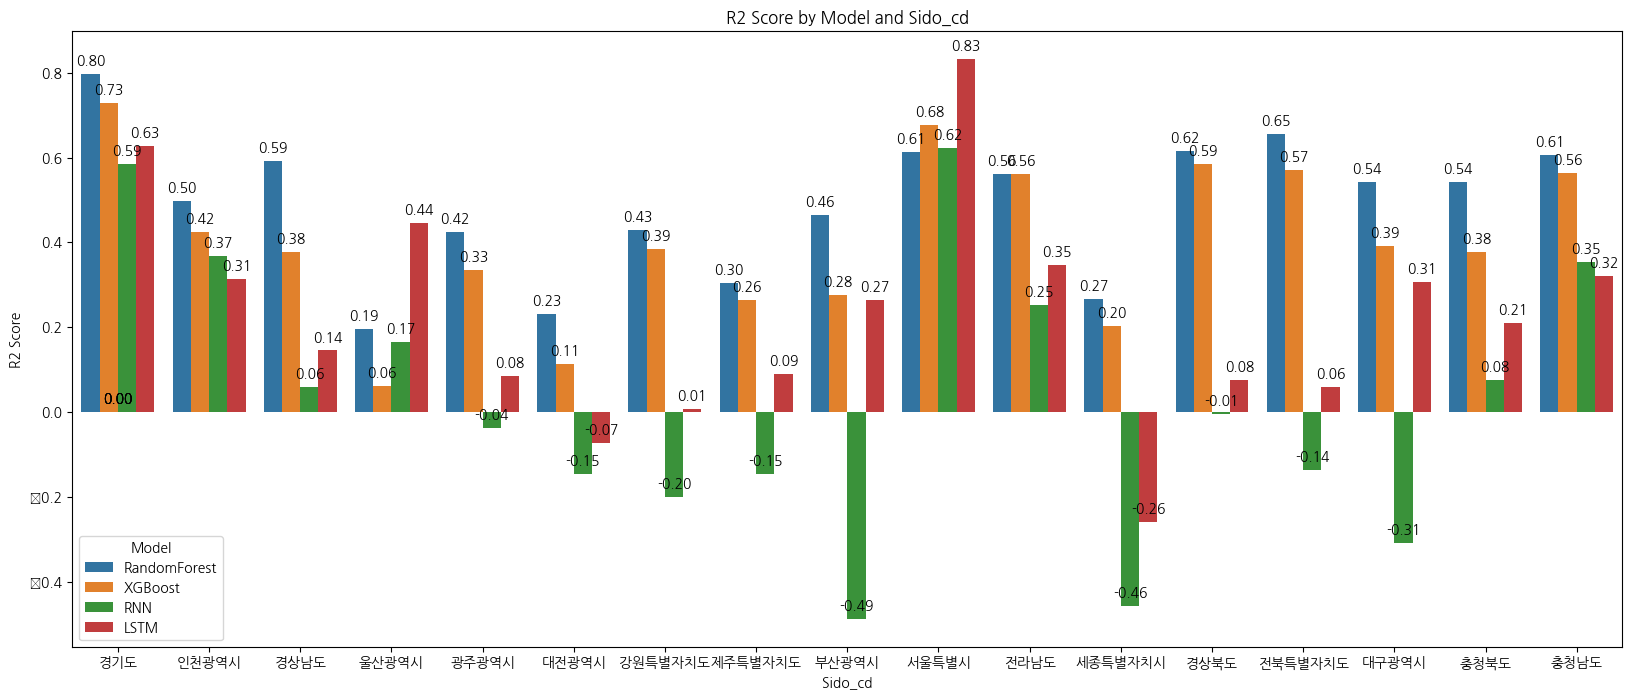

In [19]:
# 시도별 성능을 Bar Plot으로 시각화
plt.figure(figsize=(20, 8))
plt.rc('font', family=fontprop.get_name())
bar_width = 0.2  # 막대 너비

# R2 시각화
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='sido', y='r2', hue='model', data=df)
add_values_on_bars(ax)
plt.title('R2 Score by Model and Sido_cd')
plt.xlabel('Sido_cd', fontproperties=fontprop)
plt.ylabel('R2 Score', fontproperties=fontprop)
plt.legend(title='Model')
plt.show()